In [29]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import transforms
import torchvision.models as models
import gc
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from PIL import Image


In [30]:
labels = pd.read_csv("./DEAM_Annotations/annotations/avgannotations/song_level/static_train.csv", header=0, names=["song_id", "valence_mean", "valence_std", "arousal_mean", "arousal_std"])
labels
# labels.columns


,song_id,valence_mean,valence_std,arousal_mean,arousal_std
0,2,3.1,0.94,3.0,0.63
1,3,3.5,1.75,3.3,1.62
2,4,5.7,1.42,5.5,1.63
3,5,4.4,2.01,5.3,1.85
4,7,5.8,1.47,6.4,1.69
...,...,...,...,...,...
1338,1595,5.6,1.85,5.9,1.51
1339,1596,5.5,1.80,5.1,1.87
1340,1597,5.5,1.02,5.0,0.89
1341,1598,4.3,2.19,5.5,1.57


In [47]:
class DEAM(Dataset):
    """Custom dataset for mp3 files"""
    def __init__(self, label_file, data_dir, transform=None):
        self.labels = pd.read_csv(label_file, header=0, names=["song_id", "valence_mean", "valence_std", "arousal_mean", "arousal_std"])
        self.data_dir = data_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        filename = int(self.labels.iloc[idx]['song_id'])
        audio_path = os.path.join(self.data_dir, f"{filename}.png")
        if not os.path.exists(audio_path):
            raise FileNotFoundError(f"File not found: {audio_path}")

        data = cv2.imread(audio_path) 

        if self.transform:
            data = self.transform(data)
        
        target = torch.tensor([self.labels.iloc[idx]['valence_mean'], self.labels.iloc[idx]['arousal_mean']], dtype=torch.float32)

        return np.asarray(data), target

In [48]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

gc.collect()
torch.cuda.empty_cache()

cuda


In [49]:
train_labels = "./DEAM_Annotations/annotations/avgannotations/song_level/static_train.csv"
test_labels = "./DEAM_Annotations/annotations/avgannotations/song_level/static_test.csv"
train_dir = test_dir = "./DEAM_img/"

transform = transforms.Compose([
    # transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = DEAM(train_labels, train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)

test_dataset = DEAM(test_labels, test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=24)

In [50]:
class DEAMCNN(nn.Module):
    def __init__(self, num_classes):
        super(DEAMCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        fc1_input = 32 * 72 * 108
        self.fc1 = nn.Linear(fc1_input, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        fc1_input = 32 * x.size(2) * x.size(3)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/10], Loss: 16.2643, Valence Loss: 22.1634, Arousal Loss: 10.3653
Epoch [2/10], Loss: 1.2373, Valence Loss: 1.1621, Arousal Loss: 1.3124
Epoch [3/10], Loss: 1.0158, Valence Loss: 0.9118, Arousal Loss: 1.1199
Epoch [4/10], Loss: 0.9661, Valence Loss: 0.8934, Arousal Loss: 1.0387
Epoch [5/10], Loss: 0.8246, Valence Loss: 0.7908, Arousal Loss: 0.8585
Epoch [6/10], Loss: 0.6904, Valence Loss: 0.6967, Arousal Loss: 0.6841
Epoch [7/10], Loss: 0.5604, Valence Loss: 0.5828, Arousal Loss: 0.5381
Epoch [8/10], Loss: 0.4108, Valence Loss: 0.4330, Arousal Loss: 0.3886
Epoch [9/10], Loss: 0.2920, Valence Loss: 0.3299, Arousal Loss: 0.2540
Epoch [10/10], Loss: 0.1984, Valence Loss: 0.2253, Arousal Loss: 0.1715


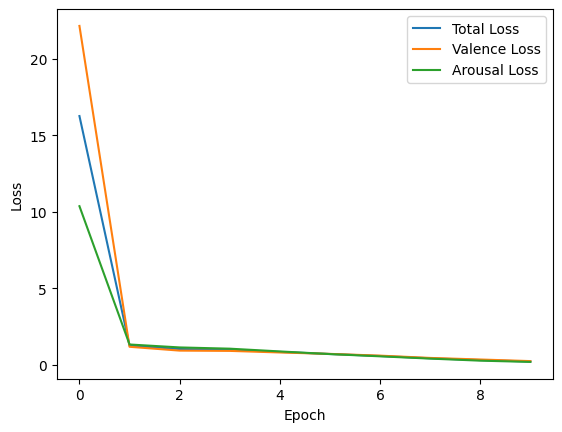

In [61]:
num_classes = 2
model = DEAMCNN(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
valence_errors_history = []
arousal_errors_history = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    valence_errors = 0.0
    arousal_errors = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        valence_targets = targets[:, 0].unsqueeze(1)
        arousal_targets = targets[:, 1].unsqueeze(1)

        loss = criterion(outputs, targets)
        valence_loss = criterion(outputs[:, 0].unsqueeze(1), valence_targets)
        arousal_loss = criterion(outputs[:, 1].unsqueeze(1), arousal_targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        valence_errors += valence_loss.item()
        arousal_errors += arousal_loss.item()

    epoch_loss /= len(train_loader)
    valence_errors /= len(train_loader)
    arousal_errors /= len(train_loader)

    train_loss_history.append(epoch_loss)
    valence_errors_history.append(valence_errors)
    arousal_errors_history.append(arousal_errors)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Valence Loss: {valence_errors:.4f}, Arousal Loss: {arousal_errors:.4f}')

plt.plot(train_loss_history, label='Total Loss')
plt.plot(valence_errors_history, label='Valence Loss')
plt.plot(arousal_errors_history, label='Arousal Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
print(loss)

tensor(0.2425, device='cuda:0', grad_fn=<MseLossBackward0>)


In [63]:
torch.save(model.state_dict(), "DEAMCNN.pth")

In [66]:
input_image_path = 'DEAM_img/2.png'

transform = transforms.Compose([
    transforms.Resize((288, 432)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(input_image_path)
input_tensor = transform(image).unsqueeze(0)

model = DEAMCNN(num_classes)
model.load_state_dict(torch.load('DEAMCNN.pth'))
model.eval()

with torch.no_grad():
    output = model(input_tensor)
print(output)
train = pd.read_csv("")

tensor([[3.8405, 4.1781]])


In [78]:
criterion = nn.MSELoss()

total_loss = 0.0
num_samples = 0
model.to(device)

model.eval()

valence_preds = []
arousal_preds = []
valence_true = []
arousal_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.to(device))
        targets = targets.to(device)

        valence_preds.extend(outputs[:, 0].cpu().numpy())
        arousal_preds.extend(outputs[:, 1].cpu().numpy())

        valence_true.extend(targets[:, 0].cpu().numpy())
        arousal_true.extend(targets[:, 1].cpu().numpy())

valence_mse = mean_squared_error(valence_true, valence_preds)
arousal_mse = mean_squared_error(arousal_true, arousal_preds)

print(f"Valence MSE: {valence_mse:.4f}")
print(f"Arousal MSE: {arousal_mse:.4f}")

Valence MSE: 0.7654
Arousal MSE: 0.8419


In [70]:
val_dir = test_dir
val_labels = "./DEAM_Annotations/annotations/avgannotations/song_level/static_val.csv"

val_dataset = DEAM(val_labels, val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=24)

In [ ]:
criterion = nn.MSELoss()

total_loss = 0.0
num_samples = 0
model.to(device)

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        total_loss += loss.item()
        num_samples += targets.size(0)

average_loss = total_loss / num_samples

print(f'Mean Squared Error on Val Set: {average_loss:.4f}')